In [1]:
# Things to pick up:
# using sk_learn to do a stratified train_test_split
# using the reduce on plateau learning rate scheduler
# start training with conv layers frozen, unfreeze more layers after we reach a plateau in training
# the unfreezing did not seem to help much for this dataset

from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.models as models
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.model_selection import train_test_split
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Use the following commands to download the pre-trained weights for VGG16
# In windows this was downloaded to: C:\Users\<<username>>\.cache\torch\hub\checkpoints
# I transferred the model over to my project folder for easy access

#import torchvision.models as models
#vgg16 = models.vgg16(pretrained=True)

# The pre-trained weights from the Pytorch were trained on the ImageNet Dataset with 1000 classes
# To test out the pre-trained classifier, we need to get the lables for the classes
# Downloaded from here: https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a
# We do some cleaning up and storing into our own dict

imagenet_classes = {}
with open("D:/data/vision_imagenet/imagenet1000_clsidx_to_labels.txt") as f:
    for line in f:
        line = line.replace(" ", "")
        line = line.replace("\n", "")
        line = line.replace("'", "")
        [key,val]=line.split(":")
        imagenet_classes[int(key)] = val

input_size = 224

# for inference, we need to resize the image to the correct size, then make it into a tensor
# the normalisation is following the Pytorch documentation, these were the parameters they used during training
transform = transforms.Compose([
        transforms.Resize([input_size,input_size]),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

# there are 4 test images in this folder I got off google: cucumber, fox, frying pan and a nemo fish
# just to test that the base classifier is working as intended
data = torchvision.datasets.ImageFolder(root = "D:/data/vision_imagenet/test_images", transform = transform)

test_data_loader = DataLoader(data, batch_size=12, shuffle = False)

net = models.vgg16()

# loading the pre-trained model
net.load_state_dict(torch.load("D:/data/vision_imagenet/vgg16_pre_trained.pth"))
net.eval()

# we need to use the softmax function on the output logits
m = nn.Softmax(dim=1)

# loading the next batch of images from the data loader, we ignore the label since we just put everythin we wanted to test in one folder
features, _ = next(iter(test_data_loader))
output = m(net.forward(features))
output = torch.argmax(output, dim=1).numpy()

# printing out the predicted classes
for i in range(len(output)):
    print(imagenet_classes[output[i]])

cucumber,cuke,
redfox,Vulpesvulpes,
fryingpan,frypan,skillet,
anemonefish,


In [3]:
#Freezing the network
for param in net.parameters():
    param.requires_grad = False
    #print(param.requires_grad)

#print(vgg16._modules["classifier"])

#Setting the new fully connected layers
net._modules["classifier"][0] = nn.Linear(in_features=25088, out_features=4096, bias=True)
net._modules["classifier"][3] = nn.Linear(in_features=4096, out_features=4096, bias=True)
net._modules["classifier"][6] = nn.Linear(in_features=4096, out_features=151, bias=True)

# checking that indeed requires_grad = True for these layers
#for name, param in vgg16.named_parameters():
#    print(str(name) + str(param.requires_grad))

In [4]:
# the task we want to achieve is to be able to correctly classify 151 classes of animals
# the dataset was obtained from Kaggle: https://www.kaggle.com/sharansmenon/animals141

# Preparing the data

transform = {
    'train': transforms.Compose([
        #transforms.Resize([input_size,input_size]),
        transforms.RandomHorizontalFlip(), # Flip the data horizontally
        transforms.RandomAffine(degrees=5,translate=(0.1,0.1),scale=(0.9,1.1)),
        #transforms.Resize(256),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        #transforms.Resize([input_size,input_size]),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

data = torchvision.datasets.ImageFolder(root = "D:/data/vision_animals")

# using sk-learn train_test_split to do the stratification

targets = np.array(data.targets)
indices = np.arange(len(targets))

train_indices,temp_indices = train_test_split(indices, test_size=0.2, stratify=targets)

#print(type(temp_indices))
#print(type(targets))

temp_targets = targets[temp_indices]

test_indices,val_indices = train_test_split(temp_indices, test_size=0.5, stratify=temp_targets)

train_set = Subset(data, indices=train_indices)
test_set = Subset(data, indices=test_indices)
val_set = Subset(data, indices=val_indices)

train_set.dataset.transform = transform['train']
test_set.dataset.transform = transform['test']
val_set.dataset.transform = transform['test']

# dataloader is used and batch_size adjusted until we fully utilize GPU ram
batch_size = 64
train_data_loader = DataLoader(train_set, batch_size=batch_size, shuffle = True)
val_data_loader = DataLoader(val_set, batch_size=batch_size, shuffle = False)
test_data_loader = DataLoader(test_set, batch_size=batch_size, shuffle = False)

# Checking if cuda is available and emptyping cuda cache
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
torch.cuda.empty_cache()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(),lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3)

#criterion = nn.BCEWithLogitsLoss()
#optimizer = torch.optim.SGD(net.parameters(),lr=1e-3)

# Sending to the GPU
net = net.to(device)

cuda


In [5]:
#variables that need to be reset for the first training
val_loss_hist=[]
loss_hist=[]
epoch = 0
min_val_loss = math.inf

In [10]:
print("Training Started")

patience = 0
num_train_samples = len(train_set)
num_val_samples = len(val_set)

for _ in range(50):
    
    epoch += 1
        
    net.train()
    epoch_loss = 0

    for i, data in enumerate(train_data_loader, 0):
        
        features, labels = data
        #labels = labels.view(-1, 1).float()
        
        features=features.to(device)
        labels=labels.to(device)
        
        optimizer.zero_grad()   # zero the gradient buffers
        
        output = net.forward(features)        
        loss = criterion(output, labels)

        epoch_loss+=loss.item()
        
        loss.backward()
        optimizer.step()    # Does the update
    
    epoch_loss = epoch_loss / num_train_samples
    loss_hist.append(epoch_loss)
    
    #print("Eval")
    net.eval()
    epoch_val_loss = 0
    
    for i, data in enumerate(val_data_loader, 0):
        
        features, labels = data
        #labels = labels.view(-1, 1).float() 
        
        features=features.to(device)
        labels = labels.to(device)
        
        output = net.forward(features)
        loss = criterion(output, labels)        
        
        epoch_val_loss+=loss.item()
    
    epoch_val_loss = epoch_val_loss / num_val_samples
    val_loss_hist.append(epoch_val_loss)
    
    scheduler.step(epoch_val_loss)
    #print("Learning Rate: " + str(optimizer.param_groups[0]['lr']))
    
    #if epoch % 5 == 0:
    print("Epoch: " + str(epoch) + ". Train Loss: " + str(epoch_loss) + ". Val Loss: " + str(epoch_val_loss))
            
    if epoch_val_loss < min_val_loss:
        min_val_loss = epoch_val_loss
        torch.save(net.state_dict(), "torchmodel/weights_best.pth")
        print('\033[93m'+"Model Saved"+'\033[0m')
        patience = 0
        
    else:
        patience += 1
    
    if (patience == 5):
        break
        
print("Training Ended")

Training Started
Epoch: 39. Train Loss: 0.0024516962990729194. Val Loss: 0.01415117172913498
Model Saved
Epoch: 40. Train Loss: 0.002102230575163678. Val Loss: 0.013847011983679812
Model Saved
Epoch: 41. Train Loss: 0.002026345990068577. Val Loss: 0.014052258724230899
Epoch: 42. Train Loss: 0.0017475261662747306. Val Loss: 0.013945510417840888
Epoch: 43. Train Loss: 0.001652937476826606. Val Loss: 0.013481804723754834
Model Saved
Epoch: 44. Train Loss: 0.0016637065046029818. Val Loss: 0.013514714948298258
Epoch: 45. Train Loss: 0.0014639889792143887. Val Loss: 0.013597702105459795
Epoch: 46. Train Loss: 0.0018367235998766412. Val Loss: 0.013744246541408071
Epoch: 47. Train Loss: 0.0014916348512072051. Val Loss: 0.013828859469917212
Epoch: 48. Train Loss: 0.0016532432713302259. Val Loss: 0.013825773052051307
Training Ended


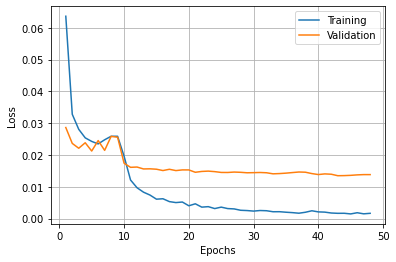

In [15]:
# Correction at epoch 8 was due to learning rate scheduling
# Next 3 layers were unfrozen at epoch 38

epoch_list=np.arange(1,len(loss_hist)+1)

start = 0
plt.plot(epoch_list[start:],loss_hist[start:])
plt.plot(epoch_list[start:],val_loss_hist[start:])
plt.legend(['Training','Validation'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.show()

In [14]:
# Perfoming accuracy check on test set
# unfreezing more layers did not help the test accuracy

net.load_state_dict(torch.load("torchmodel/weights_best.pth"))
net.eval()
m = nn.Softmax(dim=1)

accuracy = 0

for i, data in enumerate(test_data_loader, 0):
    
    features, labels = data
    features=features.to(device)
    labels=labels.to(device)
    output = m(net.forward(features))
    output = torch.argmax(output, dim=1)
    accuracy += torch.sum(output==labels)

print("Accuracy: " + str(accuracy.cpu() / len(test_set)))

Accuracy: tensor(0.7974)


In [9]:
# unfreeze 19 and above at epoch 38
# after unfreezing, we run the training cell again. variables are setup to be able to continue training.

i = 0
for name, param in net.named_parameters():
    if i > 19:
        param.requires_grad = True
    print(str(i) + " " + str(name) + " : " +str(param.requires_grad))
    i+=1

0 features.0.weight : False
1 features.0.bias : False
2 features.2.weight : False
3 features.2.bias : False
4 features.5.weight : False
5 features.5.bias : False
6 features.7.weight : False
7 features.7.bias : False
8 features.10.weight : False
9 features.10.bias : False
10 features.12.weight : False
11 features.12.bias : False
12 features.14.weight : False
13 features.14.bias : False
14 features.17.weight : False
15 features.17.bias : False
16 features.19.weight : False
17 features.19.bias : False
18 features.21.weight : False
19 features.21.bias : False
20 features.24.weight : True
21 features.24.bias : True
22 features.26.weight : True
23 features.26.bias : True
24 features.28.weight : True
25 features.28.bias : True
26 classifier.0.weight : True
27 classifier.0.bias : True
28 classifier.3.weight : True
29 classifier.3.bias : True
30 classifier.6.weight : True
31 classifier.6.bias : True
